<a href="https://colab.research.google.com/github/Re843/ml_ai_ds/blob/main/NLP%20Revathi%20Untitled6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Amazon Product Reviews NLP Pipeline



Name: Revathi Narayanan Nambiar GH1039745

Thousands of Amazon customer reviews are sent to our company, and while they contain valuable feedback, it can be difficult to gather actionable insights from them because they are unstructured.

In order to solve this, we want to create an NLP pipeline that acknowledges important discussion points and evaluates the tone of these reviews.

Product and marketing teams will benefit from this system's ability to comprehend consumer preferences and concerns.

Encouraging data-driven decisions for customer satisfaction and product enhancement is the aim.

Database Link: https://www.kaggle.com/code/yasserh/amazon-product-reviews-topic-modelling

Importing Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
!pip install gensim
# Import corpora and models from the gensim library
from gensim import corpora, models
from transformers import pipeline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Load Dataset

After loading the dataset, we choose the appropriate columns—review date, star rating, and review text. For temporal analysis, dates have been transformed into datetime format.

In [ ]:
# Load Dataset
df = pd.read_csv('/content/7817_1.csv.zip')

# Print the column names to inspect them
print(df.columns)
print(df.columns.tolist())



Index(['id', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'dimension', 'ean', 'keys', 'manufacturer',
       'manufacturerNumber', 'name', 'prices', 'reviews.date',
       'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'sizes',
       'upc', 'weight'],
      dtype='object')
['id', 'asins', 'brand', 'categories', 'colors', 'dateAdded', 'dateUpdated', 'dimension', 'ean', 'keys', 'manufacturer', 'manufacturerNumber', 'name', 'prices', 'reviews.date', 'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'sizes', 'upc', 'weight']


In [ ]:
df = pd.read_csv('/content/7817_1.csv.zip')

# Select relevant columns and drop missing data
df = df[['reviews.text', 'reviews.rating', 'reviews.date']].dropna()

# Rename for convenience
df = df.rename(columns={
    'reviews.text': 'text',
    'reviews.rating': 'rating',
    'reviews.date': 'date'
})

# Convert date to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with invalid dates (if any)
df = df.dropna(subset=['date'])

print(df.head())



                                                text  rating  \
0  I initially had trouble deciding between the p...     5.0   
1  Allow me to preface this with a little history...     5.0   
2  I am enjoying it so far. Great for reading. Ha...     4.0   
3  I bought one of the first Paperwhites and have...     5.0   
4  I have to say upfront - I don't like coroporat...     5.0   

                       date  
0 2015-08-08 00:00:00+00:00  
1 2015-09-01 00:00:00+00:00  
2 2015-07-20 00:00:00+00:00  
3 2017-06-16 00:00:00+00:00  
4 2016-08-11 00:00:00+00:00  


#Preprocessing

The review texts are cleaned and tokenized here by:

1.Removal of non-alphabetic characters

2.Making the change to lowercase

3.The elimination of stopwords

4.Lemmatizing terms

The data is now ready for sentiment analysis and topic modeling.

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub(r"[^a-zA-Z]", " ", text)  # Remove non-letters
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

print("Preprocessing reviews...")
df['tokens'] = df['text'].apply(preprocess)
df = df[df['tokens'].str.len() > 0]  # Keep only rows with tokens

Preprocessing reviews...


#Topic Modeling using LDA

We determine five significant trends in the reviews using Latent Dirichlet Allocation (LDA). We are better able to comprehend what customers discuss about by using topics.

Each topic's top words are displayed for interpretation.

In [ ]:
print("Building LDA topic model...")
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)

# Display discovered topics
for idx, topic in lda_model.print_topics():
    print(f"Topic {idx+1}: {topic}\n")

def get_dominant_topic(tokens):
    bow = dictionary.doc2bow(tokens)
    topics = lda_model.get_document_topics(bow)
    if topics:
        return max(topics, key=lambda x: x[1])[0]
    return None

df['topic'] = df['tokens'].apply(get_dominant_topic)
df = df[df['topic'].notnull()]  # remove rows with no dominant topic

Building LDA topic model...
Topic 1: 0.014*"kindle" + 0.011*"use" + 0.011*"sling" + 0.010*"one" + 0.010*"would" + 0.009*"like" + 0.008*"review" + 0.008*"book" + 0.008*"tablet" + 0.007*"case"

Topic 2: 0.025*"echo" + 0.024*"tap" + 0.013*"great" + 0.011*"kindle" + 0.010*"love" + 0.009*"would" + 0.009*"alexa" + 0.009*"book" + 0.008*"amazon" + 0.008*"like"

Topic 3: 0.025*"fire" + 0.016*"tablet" + 0.012*"amazon" + 0.012*"case" + 0.012*"kindle" + 0.010*"new" + 0.010*"remote" + 0.008*"one" + 0.007*"well" + 0.007*"model"

Topic 4: 0.019*"great" + 0.018*"speaker" + 0.018*"sound" + 0.014*"alexa" + 0.014*"amazon" + 0.013*"echo" + 0.012*"music" + 0.012*"tap" + 0.011*"use" + 0.011*"good"

Topic 5: 0.016*"cover" + 0.015*"dot" + 0.015*"look" + 0.013*"love" + 0.013*"like" + 0.012*"one" + 0.008*"bought" + 0.008*"fabric" + 0.008*"three" + 0.008*"read"



#Sentiment Analysis

In [ ]:
print("Running sentiment analysis...")
device = 0 if torch.cuda.is_available() else -1
sentiment_pipeline = pipeline("sentiment-analysis", device=device)

def analyze_sentiment(text):
    try:
        return sentiment_pipeline(text[:512])[0]['label']  # truncate text to max length for transformer
    except Exception:
        return None

df['sentiment'] = df['text'].apply(analyze_sentiment)
df = df[df['sentiment'].notnull()]  # drop rows where sentiment failed

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Running sentiment analysis...


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


For sentiment analysis, we categorize each review as neutral, negative, or positive using a transformer model that has already been trained.

## Sentiment distribution by topic


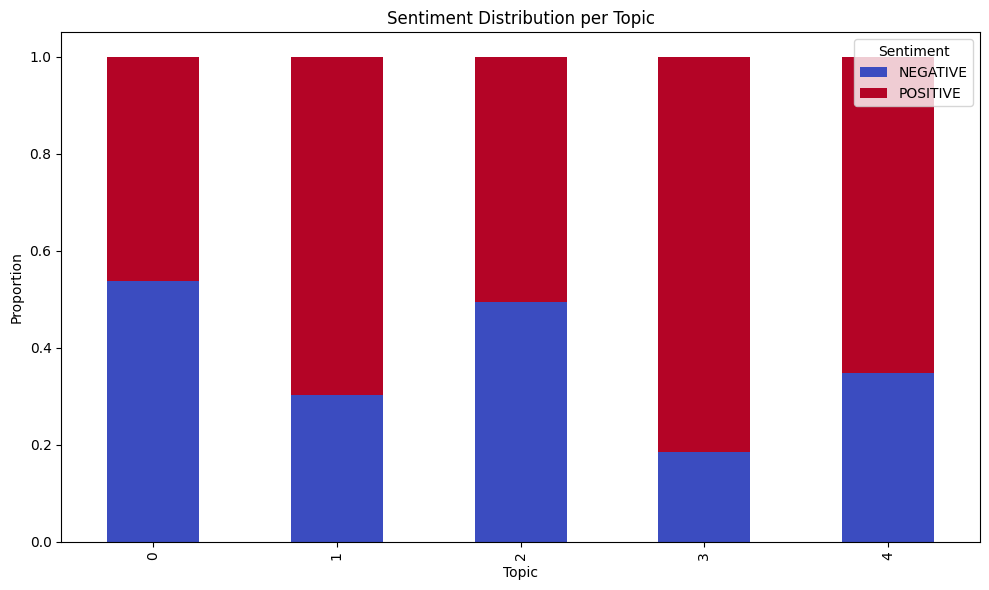

In [ ]:
topic_sentiment = df.groupby('topic')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
topic_sentiment.plot(kind='bar', stacked=True, figsize=(10,6), colormap='coolwarm')
plt.title("Sentiment Distribution per Topic")
plt.xlabel("Topic")
plt.ylabel("Proportion")
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# Topic trends over time


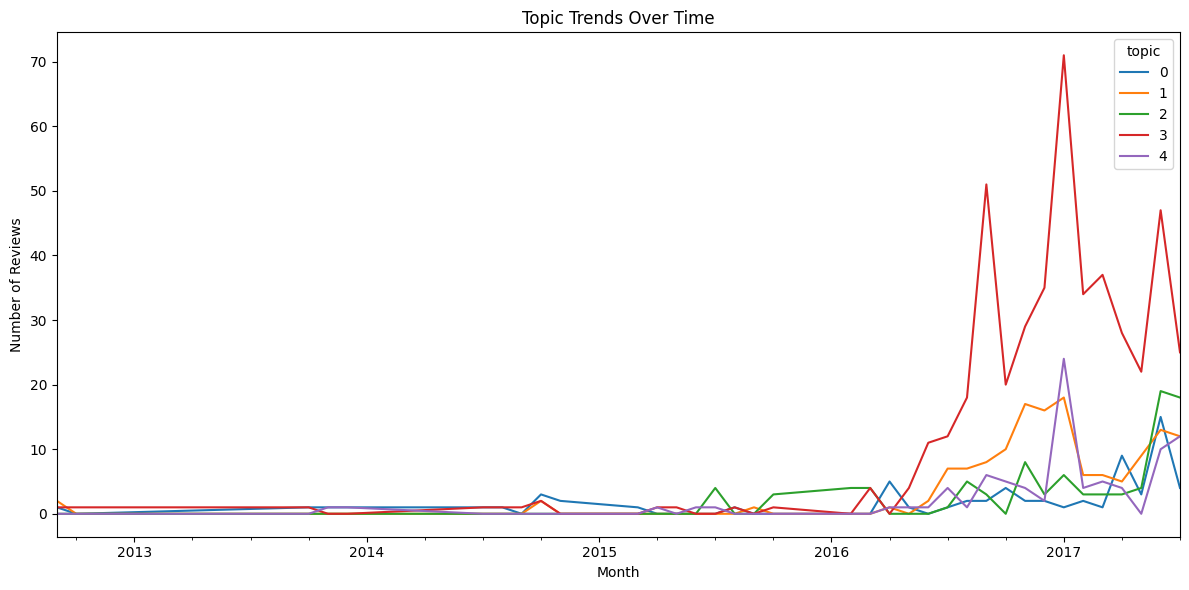

In [ ]:
df['month'] = df['date'].dt.to_period('M')
topic_trend = df.groupby(['month', 'topic']).size().unstack(fill_value=0)
topic_trend.plot(figsize=(12,6))
plt.title("Topic Trends Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

Visualizations include:

Sentiment distribution per topic

How topics trend over time

These insights help identify key customer concerns and how they evolve.



#Evaluation & Final Notes

Although this pipeline offers a good beginning, take into account:

Assessing LDA topic coherence scores

Examining topic and sentiment label samples by hand

Trying out various numbers of subjects or sophisticated models

For increased accuracy, use domain-specific sentiment models.

In [ ]:
# For production use:
# - Evaluate topic coherence (using gensim's CoherenceModel)
# - Manual inspection of topics and sentiments
# - Possible improvements: hyperparameter tuning, more advanced models

print("\nPipeline complete. Please consider manual validation and further evaluation steps.")


Pipeline complete. Please consider manual validation and further evaluation steps.
